<div align="right" style="text-align: right;"><i>Peter Norvig<br>April 2020</i></div>

# Jotto

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a word game in which a **guesser** tries to guess a secret **target** word, which is chosen from a list of permissible words, in as few guesses as possible. Each guess must be one of the permissible words, and the **reply** to each guess is the number of letters in common between the guess word and the target word, regardless of the positions of the letters.   

Here is an example Jotto game, where I show the guesses, the replies, the number of remaining targets that are **consistent** with all the replies seen so far, and finally the letters that matched (this is as an aid to you, the reader; these matching letters are not known to the guesser). In this game, the guesser gets to the target word, "wonky", in 7 guesses. 

    Guess 1: stoma, Reply: 1, Consistent targets: 1118    (Matched: "o")
    Guess 2: bairn, Reply: 1, Consistent targets: 441     (Matched: "n")
    Guess 3: swipe, Reply: 1, Consistent targets: 197     (Matched: "w")
    Guess 4: lurks, Reply: 1, Consistent targets: 87      (Matched: "k")
    Guess 5: rowdy, Reply: 3, Consistent targets: 14      (Matched: "owy")
    Guess 6: roved, Reply: 1, Consistent targets: 2       (Matched: "o")
    Guess 7: wonky, Reply: 5, Consistent targets: 1       (Matched: "wonky")


There are several variants of the game; here are four key questions and my answers:

- Q: How many letters can each word be? <br>A: **Only five-letter words are allowed in the word list**.
- Q: Can a guess be a word that is not in the word list? <br>A: **No. (If the guesser proposes a non-word, the reply is 0.)**
- Q: What is the reply for a word that has the same letter twice, like the `s` in `stars`? <br>A: **Only words with no repeated letters are allowed in the word list**.
- Q: What if the reply is `5`, but the guess is not the target?<br>A: **No two words in the word list are allowed to have the same set of five letters**.<br>**For example, only one of** `{'apers', 'pares', 'parse', 'pears', 'reaps', 'spare', 'spear'}` **is allowed.**

# Choosers and Guessers

Typically, the **guesser** plays against a **chooser**, who chooses the target word. This introduces a game-theoretic aspect: the chooser chooses a word that should be difficult for the guesser, but knowing that, the guesser modifies their strategy, and knowing that, the chooser further modifies their choice, etc. To avoid these complications, I will instead use a scenario where every target word is equally likely, and to evaluate a guesser we have it play one game with each target word, and aggregate the scores from all those games. (This is appropriate when the guesser is a program, but would be extremely tedious for a human guesser.)

First some imports and (if necessary) the download of a file of words, `sgb-words.txt`:

In [1]:
import matplotlib.pyplot as plt
import random
from typing      import List, Tuple, Dict, Union
from statistics  import mean, stdev
from collections import defaultdict, Counter
from math        import log

! [ -e sgb-words.txt ] || curl -O https://norvig.com/ngrams/sgb-words.txt

We can make a Jotto word list from `sgb-words.txt` by putting all the words that have five distinct letters into a dict keyed by the set of letters in each word, and then keeping only one word for each letter set:

In [2]:
def jotto_words(words) -> List[str]:
    """Build a list of permissible Jotto words from an iterable of words."""
    lettersets = {frozenset(w): w 
                  for w in words if len(w) == 5 == len(frozenset(w))}
    return list(lettersets.values())

In [3]:
wordlist = jotto_words(open('sgb-words.txt').read().split())
len(wordlist)

2845

We see there are 2,845 permissible target words.

# Playing a Game

We will define the function `play_jotto` to play a game and optionally produce the output shown above in the example game (without the "(Matched: ...)" part), and finally return as a score the number of guesses made. To avoid a possible infinite loop with a very poor guesser, we limit the number of guesses to the number of words in the word list.

The first argument to `play_jotto` is a `guesser`. I choose to implement a guesser as a `callable` (e.g., a function) that is passed the current state of the game and returns a guess word. So how do we represent the state of the game? `play_jotto` is keeping track of the `targets` that are still consistent given previous guesses and replies, so we might as well pass that in. In addition, we pass in the reply from the previous guess. Note that a guess need not be one of the consistent targets, but it must be one of the words in the word list.  The second argument is a `chooser`: a function that selects a word from a wordlist. By default, it chooses randomly.

In [4]:
def play_jotto(guesser, chooser=random.choice, wordlist=wordlist, verbose=False) -> int:
    """How many guesses does it take for `guesser` to guess the Jotto target word,
    which is selected by `chooser` from the words in `wordlist`?"""
    targets = wordlist # The targets that are consistent with all replies
    target  = chooser(targets)
    reply   = None
    for i in range(1, len(wordlist) + 1):
        guess = guesser(reply, targets)
        reply = reply_for(target, guess) if guess in wordlist else -1
        targets = [w for w in targets if reply_for(guess, w) == reply]
        if verbose: 
            print(f'Guess {i}: {guess}, Reply: {reply}, Consistent targets: {len(targets)}')
        if guess == target or i == len(wordlist):  
            return i
        
Reply = int # A reply to a guess is an integer (from 0 to 5)
                         
def reply_for(target, guess) -> Reply: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

# Random Guesser

One simple guesser function is `random_guesser`: from the remaining consistent  targets, pick one at random. That sounds hopelessly naive, but it is actually a decent strategy:

In [5]:
def random_guesser(_, targets) -> str: return random.choice(targets)

play_jotto(random_guesser, verbose=True)

Guess 1: delis, Reply: 3, Consistent targets: 410
Guess 2: coeds, Reply: 2, Consistent targets: 210
Guess 3: dirts, Reply: 2, Consistent targets: 97
Guess 4: veldt, Reply: 2, Consistent targets: 44
Guess 5: adieu, Reply: 2, Consistent targets: 17
Guess 6: child, Reply: 5, Consistent targets: 1


6

# Evaluating Guessers

That was just one sample game. How well will this guesser do averaged over all target words? The function `play_jottos` plays a game against every target and collects the scores. Then, `show` displays a histogram and the mean, standard deviation, and worst case number of guesses. 

In [6]:
def play_jottos(guesser, targets=wordlist) -> List[int]:
    """Scores for this guesser on all targets."""
    return [play_jotto(guesser, lambda _: target, wordlist, verbose=False)
            for target in targets]
    
def show(scores: List[int]):
    """Show a histogram and statistics for these scores."""
    bins = range(min(scores), max(scores) + 2)
    plt.hist(scores, align='left', rwidth=0.9, bins=bins,
             weights=[100 / len(scores) for _ in scores])
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses to find target'); plt.ylabel('% of targets')
    print(f'mean = {mean(scores):.2f} ± {stdev(scores):.2f} guesses; worst = {max(scores)}')

mean = 7.32 ± 1.66 guesses; worst = 16


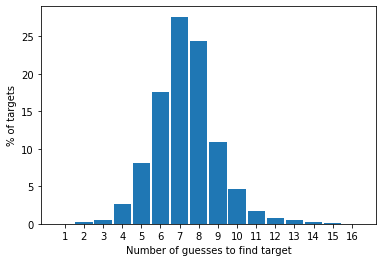

In [7]:
show(play_jottos(random_guesser))

The average is a bit more than 7 guesses; 2/3 of the time it will take from 6 to 9 guesses, and the worst case is 18 guesses. Can we improve the average and/or worst case?

#  Guessers that Partition Targets

A key idea in guessing is to reduce the number of consistent targets. We can think of a guess as **partitioning** the consistent targets into different **branches** of a tree, each branch corresponding to a different reply:

In [8]:
def partition(guess, targets) ->  Dict[Reply, List[str]]:
    """A partition of targets by the possible replies to guess: {reply: [word, ...]}."""
    branches = defaultdict(list)
    for target in targets:
        branches[reply_for(target, guess)].append(target)
    return branches

It would take too much space to show a partition of all 2,845 words, so here's a partition of just the first 22 words:

In [9]:
partition('girth', wordlist[:22])

defaultdict(list,
            {4: ['their', 'might'],
             1: ['about', 'sword', 'resay', 'nuder', 'house'],
             0: ['would', 'cloud', 'place', 'sound', 'fondu'],
             3: ['throe', 'write', 'rifts', 'think', 'grate'],
             2: ['water', 'after', 'ethos', 'while'],
             5: ['girth']})

We see that after guesssing `'girth'` we will be left with no more than five consistent targets, no matter what the reply.

To decide which guess is best, we don't need to know the identity of all the words in each branch, just the *count* of how many there are. The function `partition_counts` computes that,  returning a list of counts, one for each possible reply:

In [10]:
def partition_counts(guess, targets) -> List[int]: 
    "A partition: {reply: number_of_targets_with_reply, ...}."
    counts = Counter(reply_for(guess, target) for target in targets)
    return [counts[i] for i in all_possible_replies]

all_possible_replies = range(6)

Below are the partition counts for two possible first guesses, `ouija` and `coder`:

In [11]:
partition_counts('ouija', wordlist)

[175, 1848, 755, 65, 1, 1]

We see that for the guess `'ouija'`,  1848 consistent targets (about 2/3 of the word list) are bunched into one branch, meaning that 2/3 of the time you will be left with 1848 targets after guessing `'ouija'`. (*Note:* Why is this so? Because `'ouija'` has all the vowels except `'e'`, and about 2/3 of the words have exactly one of these vowels, so the reply for those words is 1. Only one other word, `'audio'`, has these four vowels. Only 56 words have a `'j'`, so that is not a major factor.)

In [12]:
partition_counts('coder', wordlist)

[433, 1030, 1014, 327, 40, 1]

For the guess `'coder'`, the targets are more spread out over multiple branches. After guessing `'coder'` you will never be left with more than 1030 consistent targets. That suggests that `'coder'` is a better first guess, and it suggests a general strategy: **guess the word that best partitions the consistent targets into small branches.**

What's a good metric for measuring how **small** the branches are? What we really want to know is how many additional guesses it will take to handle each branch, but since we don't know that, we can use one of the following proxy metrics:

- A simple metric is to **minimize the maximum number in the partition counts**. That is, we should deduce that `coder`, with its `max` partition count of 1030, is a better guess than `ouija`, with its `max` of 1848. 

- A more sophisticated metric is to **minimize the expected value of the partition counts**: in probability theory the expected value or **expectation** is the weighted average of a random variable. Here it means the sum, over all branches, of the size of the branch multiplied by the probability of ending up in the branch.

- Information theory provides a suggestion to **maximize the entropy in the partition counts**. Entropy is similar to expectation, except that it weights each branch size by its base 2 logarithm (whereas expectation weights it by its actual size). Note that we want to minimize *negative* entropy.

In [13]:
def expectation(counts) -> float:
    "Given a list of counts, give the expected count."
    def P(x, scale=1/sum(counts)): return scale * x
    return sum(P(x) * x for x in counts)

def entropy(counts) -> float: 
    """Information theoretic entropy of a list of counts."""
    def P(x, scale=1/sum(counts)): return scale * x
    return - sum(P(x) * log(P(x), 2) for x in counts if x)

def negative_entropy(counts) -> float: return - entropy(counts)

Here are the top 10 guesses according to each of the three metrics:

In [14]:
def top(metric, n=10, words=wordlist) -> str: 
    """The top n words according to metric(partition_counts(w, words))."""
    return ' '.join(sorted(words, key=lambda w: metric(partition_counts(w, words)))[:n])

In [15]:
top(max) # minimize the maximum number

'wader cadre armed diner coder padre rayed raved delta drone'

In [16]:
top(expectation) # minimize the expectation

'raved debar roved orbed wader armed fader dater alder cadre'

In [17]:
top(negative_entropy) # maximize the entropy (by minimizing negative entropy)

'debar alder raved dater cadre armed garde wader lased padre'

The three metrics yield a lot of overlap; `wader`, `raved`, `armed` and `cadre` appear in the top 10 for all three. Every word has both a `'d'` and an `'e'`, and 28 out of 30 have an `'r'`. Which metric is best? We have the tools to answer that: we could use `play_jottos` to get scores for guessers that use each metric. But that would take a long time. It takes about 5 seconds to compute the `top` word for just the first guess; I don't want to repeat that computation 3 × 2,845 times (and that's just for choosing the first word).

#  Guesser Trees 

I can speed up computation by precomputing a **guesser tree**: a tree that keeps partitioning target words into branches until every branch holds a single word (we call that a leaf). Think of the tree as a universal strategy that we can  apply to every target word with no need for additional computation&mdash;just branch-following in the tree.  I define a guesser tree as either:
- A **leaf**, which is a string, such as `'coder'`, indicating that this is the sole remaining consistent target. Every word in the word list should appear as a leaf in exactly one place in the guesser tree.
- An **interior node**, which is a tuple of a guess and a dict of branches, `(guess, {reply: subtree, ...})`, where the reply is an integer, 0 to 5, and each subtree covers all the target words that are consistent with that reply.

In [18]:
Leaf = str
Node = Tuple[str, Dict[Reply, 'Tree']]
Tree = Union[Leaf, Node]    # A Tree is a Node or a Leaf
GUESS, BRANCHES = 0, 1      # Indexes into a Node tuple

The function `make_tree(metric, targets)` builds a tree that covers all the targets and that, at every node, guesses a word that  minimizes the `metric` applied to the `partition_counts` of the guess.

In [19]:
def make_tree(metric, targets=wordlist) -> Tree:
    """Make a tree that guesses to minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return (guess, {reply: make_tree(metric, branches[reply]) 
                        for reply in sorted(branches)})

Here is a tree that covers five words by always making the guess that minimizes the **maximum** number in the partition counts:

In [20]:
words5 = ['purge', 'bites', 'sulky', 'patsy', 'hayed']
tree5  = make_tree(max, words5)
tree5

('bites',
 {1: ('purge', {1: ('sulky', {1: 'hayed', 5: 'sulky'}), 5: 'purge'}),
  2: 'patsy',
  5: 'bites'})

The tree says that the first guess is `'bites'`, and if the reply is `1` there is a complex subtree to consider (starting with the guess `'purge'`), but if the reply is `2` the target can only be `'patsy'` and of course if the reply is `5` then `'bites'` was the target.

# Turning a Tree into a Callable Guesser

Now that we've made a tree, we need to use it as a component of a guesser that `play_jotto` can call upon. A `TreeGuesser` is an object that stores a tree in the `self.root` and `self.tree` attributes, and while the game is being played, it follows branches in the tree, choosing the guess indicated at each node. This is done within the `__call__` method, because `play_jotto` expects a callable.  Note that on the first turn of a new game the reply will be `None`, in which case we reset `self.tree` to be the root tree. For subsequent turns, we follow the branch indicated by the reply. 

In [21]:
class TreeGuesser:
    """Given a guesser tree, use it to create a callable that can play_jotto."""
    def __init__(self, tree): self.root = self.tree = tree
        
    def __call__(self, reply, _) -> str:
        self.tree = self.root if reply is None else self.tree[BRANCHES][reply]
        return self.tree if isinstance(self.tree, str) else self.tree[GUESS]

Here's how we play a game with the five-word list:

In [22]:
play_jotto(TreeGuesser(tree5), wordlist=words5, verbose=True)

Guess 1: bites, Reply: 1, Consistent targets: 3
Guess 2: purge, Reply: 1, Consistent targets: 2
Guess 3: sulky, Reply: 1, Consistent targets: 1
Guess 4: hayed, Reply: 5, Consistent targets: 1


4

And here we build a tree over the whole word list and use it to play a game:

In [23]:
tree    = make_tree(max)
guesser = TreeGuesser(tree)

play_jotto(guesser, verbose=True)

Guess 1: wader, Reply: 3, Consistent targets: 319
Guess 2: sword, Reply: 1, Consistent targets: 131
Guess 3: paled, Reply: 3, Consistent targets: 56
Guess 4: cadet, Reply: 4, Consistent targets: 15
Guess 5: hated, Reply: 5, Consistent targets: 1


5

# Making Inconsistent Guesses

So far,  we have always guessed one of the consistent targets. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it *is* a good strategy to guess such a word.

I will redefine `make_tree` so that it is passed both the list of consistent target words and the complete word list. It also has a flag, `inconsistent`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only consistent targets are considered, as before. 

In [24]:
def make_tree(metric, targets=wordlist, wordlist=wordlist, inconsistent=False) -> Tree:
    """Make a tree that guesses to minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        words = wordlist if (inconsistent and len(targets) > 3) else targets
        guess = min(words, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return (guess, {reply: make_tree(metric, branches[reply], wordlist, inconsistent) 
                        for reply in sorted(branches)})

Here we see that by default, `make_tree` behaves just as it did before:

In [25]:
make_tree(max, words5)

('bites',
 {1: ('purge', {1: ('sulky', {1: 'hayed', 5: 'sulky'}), 5: 'purge'}),
  2: 'patsy',
  5: 'bites'})

But when allowed `make_tree` to guess an inconsistent word, it comes up with a different tree:

In [26]:
tree5b = make_tree(max, words5, inconsistent=True)
tree5b

('dashy', {0: 'purge', 1: 'bites', 2: 'sulky', 3: 'patsy', 4: 'hayed'})

This tree guesses an inconsistent word, `dashy`, with the first guess. There is no chance that this is the target, but it sets us up so that we will always be able to get the target on the second guess. That means that both the average and the worst case number of guesses is 2 for `tree5b`:

In [27]:
play_jottos(TreeGuesser(tree5b), words5)

[2, 2, 2, 2, 2]

In [28]:
mean(_), max(_)

(2, 2)

In contrast, `tree5`  has an average score of 2.4, and can take up to four guesses in the worst case:

In [29]:
play_jottos(TreeGuesser(tree5), words5)

[2, 1, 3, 2, 4]

In [30]:
mean(_), max(_)

(2.4, 4)

So the tree with an inconsistent guess is better both in the average  and in the worst case.

# Comparing Metrics

Now we will compare six guessers derived from `make_tree`:
- Minimizing either `max`, `expectation`, or `negative_entropy`.
- For each of the above, guessing either consistent targets only or allowing inconsistent targets.

The function `show_metric` makes the appropriate `TreeGuesser` and calls `play_jottos` and `show` to display results:

In [31]:
def show_metric(metric, inconsistent):
    """Show statistics and histogram for a guesser that minimizes `metric` over partition counts."""
    tree = make_tree(metric, inconsistent=inconsistent)
    guesser = TreeGuesser(tree)
    show(play_jottos(guesser))

# Comparing Metrics with Consistent Guesses Only

mean = 7.15 ± 1.81 guesses; worst = 18
CPU times: user 12.6 s, sys: 29.5 ms, total: 12.6 s
Wall time: 12.6 s


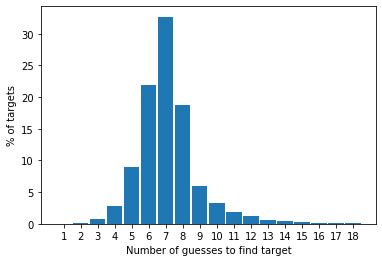

In [32]:
%time show_metric(max, False)

mean = 7.14 ± 1.82 guesses; worst = 17
CPU times: user 13 s, sys: 59.7 ms, total: 13.1 s
Wall time: 13.2 s


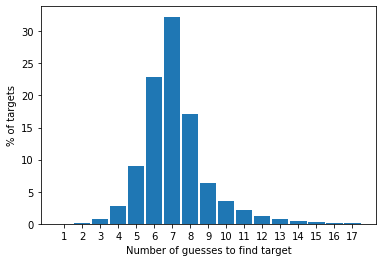

In [33]:
%time show_metric(expectation, False)

mean = 7.09 ± 1.79 guesses; worst = 19
CPU times: user 13.6 s, sys: 87.6 ms, total: 13.6 s
Wall time: 14.6 s


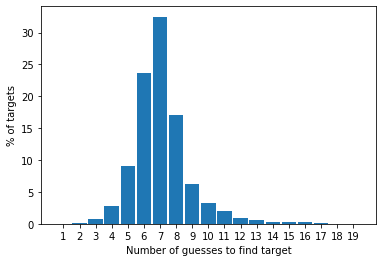

In [34]:
%time show_metric(negative_entropy, False)

# Comparing Metrics with Inconsistent Guesses Allowed

mean = 7.05 ± 0.98 guesses; worst = 10
CPU times: user 38.2 s, sys: 134 ms, total: 38.4 s
Wall time: 38.5 s


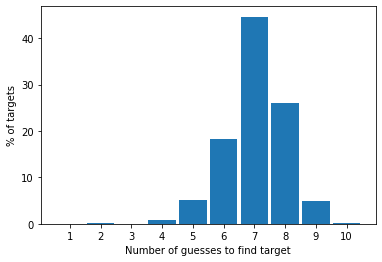

In [35]:
%time show_metric(max, True)

mean = 6.84 ± 0.95 guesses; worst = 10
CPU times: user 39.9 s, sys: 183 ms, total: 40.1 s
Wall time: 40.5 s


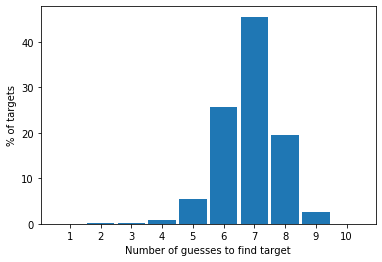

In [36]:
%time show_metric(expectation, True)

mean = 6.81 ± 1.00 guesses; worst = 10
CPU times: user 41.2 s, sys: 242 ms, total: 41.5 s
Wall time: 42.1 s


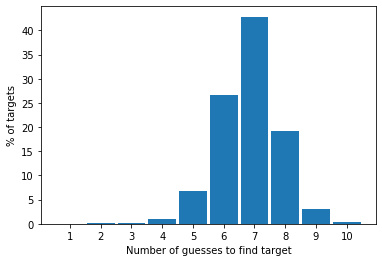

In [37]:
%time show_metric(negative_entropy, True)

# Jotto Summary

Here's a table of results:

|<br>Algorithm|Consistent<br>Mean (Max)|Inconsistent<br>Mean (Max)|
|--|--|--|
|baseline random guesser|7.38 (18)|  |
|min(max(partition_counts))|7.15 (18)|7.05 (10)|
|min(expectation(partition_counts))|7.14 (17)|6.84 (10)|
|max(entropy(partition_counts))|7.09 (19)|6.81 (10)|

So we started out with a mean of 7.38 and a worst score of 18 with the random guesser, and were able to improve by half a guess to a mean of 6.81 and a worst score of 10 using  maximization of entropy over partition counts, with inconsistent guesses allowed.

# Next Steps

There are many directions you could take this if you are interested:
- Try different length words.
- Allow words with repeated letters, like `stars`.
- Have each reply consist of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position.
- Apply the same techniques to related games, like Mastermind.
- Examine the strategy that a chooser would use, and how the guesser responds to that. Is there an equilibrium?
- Our `make_tree` function is **greedy** in that it guesses the word that minimizes some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**? Perhaps with a beam search?
- Can you improve a tree by editing it? Given a tree, look for interior nodes that have a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words).
- Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
- What else can you explore?